In [12]:
from multiprocessing import Pool
from multiprocessing import Manager
import pycbc
import numpy as np
import scipy
import matplotlib.pyplot as plt
from pycbc.frame import read_frame
from pycbc.psd import welch, interpolate
from pycbc.filter import highpass, matched_filter,lowpass

In [20]:
from pycbc.waveform import get_fd_waveform
from gstlal_psd import gstlal_psd, generate_psd_blocks, partition_time_series

In [8]:
#read in data
channel_name = "H1:GWOSC-4KHZ_R1_STRAIN"
h1 = read_frame('H-H1_GWOSC_O3b_4KHZ_R1-1257852928-4096.gwf', channel_name)
h11 = np.nan_to_num(h1,nan=0)
h11 = np.nan_to_num(h1,nan=0)
h1 = pycbc.types.timeseries.TimeSeries(h11, delta_t=h1.delta_t)
h1 = highpass(h1, 10, 8)
psd2 = interpolate(welch(h1,seg_len = int((1/h1.delta_t)*8),seg_stride = int((1/h1.delta_t)*4)),1/h1.duration)

In [9]:
f_sample = float(1/h1.delta_f)
N = int(f_sample*32)
Z = int(f_sample*8)
n_med = 7
n_avg = 64

In [31]:
delta_f = 1/(N*h1.delta_t)
print(delta_f)

0.03125


In [51]:
ra = 5.3
dec = 4.5
psi = 2.6
tgps = 0
det_H1 = pycbc.detector.Detector('H1')
#antennna sensitivity
fp, fc = det_H1.antenna_pattern(right_ascension=ra, declination=dec, polarization=psi, t_gps=tgps)
#frequency range
minf = 20

mass1_det_frame = 100
mass2_det_frame = 100
distance_inj = 4500.  # in Mpc
inclination_inj = np.pi/4
phase_inj = 0.
flow = 20.
t0_inj = 300
fmax = 1600
# generate waveform
hpf, hcf = get_fd_waveform(approximant="IMRPhenomD",
                                        mass1 = mass1_det_frame,
                                        mass2 = mass2_det_frame,
                                        distance = distance_inj,
                                        inclination = inclination_inj,
                                        coa_phase = phase_inj,
                                        f_lower=flow, f_final=1/(2*h1.delta_t),
                                        delta_f=delta_f)

template = fp*hpf + fc*hcf

In [52]:
print(len(template))
print(template.delta_f)
print(delta_f)

65537
0.03125
0.03125


In [14]:
snr_gstlal = gstlal_psd(h1, N, Z, n_med, n_avg, template)

In [15]:
gstlal_psd_blocks = generate_psd_blocks(h1,N,Z,n_med,n_avg)

In [41]:
reference_psd = gstlal_psd_blocks[0]
reference_psd = pycbc.types.frequencyseries.FrequencySeries(reference_psd, delta_f = 1/(len(reference_psd)*h1.delta_t))
print(len(reference_psd))
print(len(h1))
#interpolate reference psd
reference_psd_interpolated = interpolate(reference_psd, h1.delta_f)
print(len(reference_psd_interpolated))

131072
16777216
16777089


In [21]:
gw_data_list = partition_time_series(h1, N, Z)

In [53]:
print(len(template))
print(len(gw_data))

65537
131072


In [62]:
snr_list = []
for psd, gw_data in zip(gstlal_psd_blocks, gw_data_list):
    whiten_psd = np.sqrt(psd)*np.sqrt(reference_psd)
    
    #adjust the frequency resolution
    whiten_psd = pycbc.types.frequencyseries.FrequencySeries(whiten_psd, delta_f = 1/(len(psd)*gw_data.delta_t))

    # Ensure the PSD is in the correct format
    whiten_psd = interpolate(whiten_psd, gw_data.delta_f)
    
    
    # resize the psd
    whiten_psd.resize(len(gw_data)//2 +1)

    # Compute the SNR time series
    snr = matched_filter(template, gw_data, psd=whiten_psd, low_frequency_cutoff=10.0)
    overlap = int(N // 2 + Z)
    #snr = snr[0:len(snr) - overlap]
    snr = snr.crop(12,12)
    snr_list.append(snr)

In [64]:
gstlal_snr = np.concatenate(snr_list, axis = None)

In [65]:
print(len(gstlal_snr))
print(len(SNR_orig_psd))

16449536
16728064


In [36]:
# generate waveform
hpf, hcf = get_fd_waveform(approximant="IMRPhenomD",
                                        mass1 = mass1_det_frame,
                                        mass2 = mass2_det_frame,
                                        distance = distance_inj,
                                        inclination = inclination_inj,
                                        coa_phase = phase_inj,
                                        f_lower=flow, f_final=1/(2*h1.delta_t),
                                        delta_f=h1.delta_f)

template = fp*hpf + fc*hcf
SNR_orig_psd = matched_filter(template, h1, psd=psd2, low_frequency_cutoff=10.0)
#SNR_orig_psd = SNR_orig_psd.crop(4+4,4)

In [10]:
gstlal_sample_times = np.linspace(0,SNR_orig_psd.duration,len(snr_gstlal))
print(len(gstlal_sample_times))

16449536


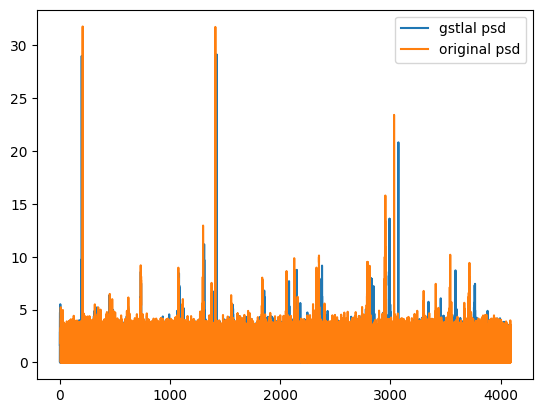

In [11]:
plt.plot(gstlal_sample_times, abs(snr_gstlal), label = 'gstlal psd')
plt.plot(SNR_orig_psd.sample_times.data,abs(SNR_orig_psd), label = 'original psd')
plt.legend()

(0.0, 30.0)

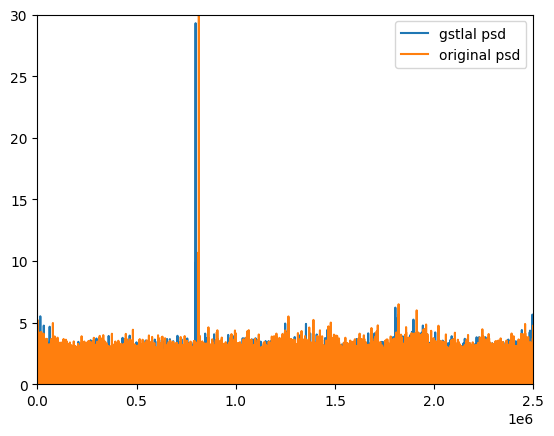

In [66]:
plt.plot(abs(gstlal_snr), label = 'gstlal psd')
plt.plot(abs(SNR_orig_psd),label = 'original psd')
plt.legend()
plt.xlim(0,0.25e7)
plt.ylim(0,30)

Text(0.5, 0, '$|z|^{2}$')

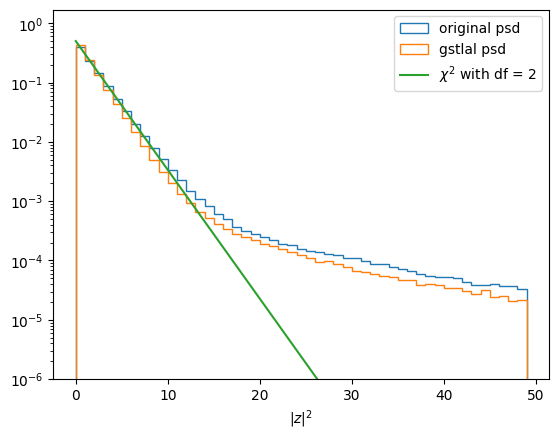

In [68]:
bins = np.arange(50)
plt.hist(abs(SNR_orig_psd)**2, histtype = 'step', bins = bins,density = True , label = 'original psd')
plt.hist(abs(gstlal_snr)**2, histtype = 'step', bins = bins,density = True, label = 'gstlal psd')
plt.plot(np.arange(50), 0.5*np.exp(-0.5*np.arange(50)), label = '$\chi ^{2}$ with df = 2')
plt.yscale('log')
plt.ylim(bottom=1e-6)
plt.legend()
plt.xlabel('$|z|^{2}$')